# 时间序列的交叉训练并进行验证(50条航线）
1. 交叉训练
2. 构建时间序列进行预测，并进行验证
3. 固定出发日期，预测提前15天票价信息，比如哪一天买最便宜

问题： 
1. 输出文件的特征没有统计量信息
2. 0-49列不知道输出的是什么
3. 预测信息的延迟是什么原因

In [67]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import time
import re # 正则表达式
from matplotlib.dates import AutoDateLocator,DateFormatter

In [1]:
inputfile='../datasets/top500_airroute_feature_preprocessed_1.csv' # 训练的数据结构及预测一天
model_file='../model/top500_airroute_timeseries_xgb_cv_1.pkl'             # 模型文件

In [305]:
# 加载模型
# model=joblib.load(model_file)

In [49]:
%time df=pd.read_csv(inputfile,parse_dates=['dep_date','search_date']) #读取文件时自动转换日期格式

CPU times: user 20.3 s, sys: 1.14 s, total: 21.4 s
Wall time: 21.4 s


In [73]:
df.label

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
6           0.0
7           0.0
8           0.0
9           0.0
10          0.0
11          0.0
12          0.0
13          0.0
14          0.0
15          0.0
16          0.0
17          0.0
18          0.0
19          0.0
20          0.0
21          0.0
22          0.0
23          0.0
24          0.0
25          0.0
26          0.0
27          0.0
28          0.0
29          0.0
           ... 
2031770    49.0
2031771    49.0
2031772    49.0
2031773    49.0
2031774    49.0
2031775    49.0
2031776    49.0
2031777    49.0
2031778    49.0
2031779    49.0
2031780    49.0
2031781    49.0
2031782    49.0
2031783    49.0
2031784    49.0
2031785    49.0
2031786    49.0
2031787    49.0
2031788    49.0
2031789    49.0
2031790    49.0
2031791    49.0
2031792    49.0
2031793    49.0
2031794    49.0
2031795    49.0
2031796    49.0
2031797    49.0
2031798    49.0
2031799    49.0
Name: label, Length: 203

In [50]:
df.pre_day.head()

0     0
1    44
2    43
3    42
4    41
Name: pre_day, dtype: int64


第一轮训练：42.930573  
只保留历史价格特征：  


In [54]:
# 训练特征
train_feature=df.columns.drop(['minprice','dep_date','search_date','arr_city','dep_city','route'])
# train_feature=train_feature.drop(columns_by_preday_stats)
# train_feature=train_feature.drop(columns_by_preday_stats)
# train_feature=train_feature.drop(columns_by_dep_stats)
len(train_feature)

70

## 构建交叉训练集
交叉验证根据时间顺序将训练集划分为6-fold，刚好预测7天的数  
fold1: train[1],test[2]  
fold2: train[1,2],test[3]  
fold3: train[1,2,3],test[4]  
fold4: train[1,2,3,4],test[5]  
fold5: train[1,2,3,4.5],test[6]  
fold5: train[1,2,3,4.5,6],test[7]  
test 集也作为时间序列的val集对训练结果进行验证  
dep start:2016-03-01,dep end:2018-05-09

In [55]:
train1=df.loc[(df.dep_date>='2016-2-1')&(df.dep_date<'2016-7-1')]
train2=df.loc[(df.dep_date>='2016-7-1')&(df.dep_date<'2016-12-1')]
train3=df.loc[(df.dep_date>='2016-12-1')&(df.dep_date<'2017-6-1')]
train4=df.loc[(df.dep_date>='2017-6-1')&(df.dep_date<'2017-11-1')]
train5=df.loc[(df.dep_date>='2017-11-1')&(df.dep_date<'2018-6-1')]
print('整体数据集：',df.shape, '\n训练集1：',train1.shape,
      '\n训练集2：',train2.shape,'\n训练集3：',train3.shape,
     '\n训练集4：',train4.shape,'\n训练集5：',train5.shape )
# print('model.best_iteration:',model.best_iteration)
#     print('model.best_score:',model.best_score)

整体数据集： (2031800, 76) 
训练集1： (339750, 76) 
训练集2： (344250, 76) 
训练集3： (409500, 76) 
训练集4： (344250, 76) 
训练集5： (477000, 76)


In [56]:
# 第一轮训练
train_df=pd.concat([train1, train2, train3, train4])
test_df=train5
%time model=fit_evaluate(train_df,test_df)
print('第一轮训练：',model.best_iteration,model.best_score)

[0]	train-rmse:717.768	test-rmse:666.491
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[1]	train-rmse:696.603	test-rmse:646.821
[2]	train-rmse:676.041	test-rmse:627.709
[3]	train-rmse:656.11	test-rmse:609.183
[4]	train-rmse:636.778	test-rmse:591.222
[5]	train-rmse:618.033	test-rmse:573.797
[6]	train-rmse:599.889	test-rmse:556.929
[7]	train-rmse:582.266	test-rmse:540.539
[8]	train-rmse:565.19	test-rmse:524.673
[9]	train-rmse:548.631	test-rmse:509.279
[10]	train-rmse:532.579	test-rmse:494.352
[11]	train-rmse:517.038	test-rmse:479.907
[12]	train-rmse:501.951	test-rmse:465.887
[13]	train-rmse:487.324	test-rmse:452.291
[14]	train-rmse:473.148	test-rmse:439.115
[15]	train-rmse:459.44	test-rmse:426.383
[16]	train-rmse:446.125	test-rmse:414.019
[17]	train-rmse:433.225	test-rmse:402.045
[18]	train-rmse:420.737	test-rmse:390.451
[19]	train-rmse:408.618	test-rmse:379.214
[20]	train-rmse:396.876	test-r

[191]	train-rmse:75.4204	test-rmse:77.9694
[192]	train-rmse:75.3947	test-rmse:77.973
[193]	train-rmse:75.3717	test-rmse:77.9788
[194]	train-rmse:75.3535	test-rmse:77.9791
[195]	train-rmse:75.3412	test-rmse:77.9746
[196]	train-rmse:75.3149	test-rmse:77.9721
[197]	train-rmse:75.2939	test-rmse:77.9707
[198]	train-rmse:75.2579	test-rmse:77.9686
[199]	train-rmse:75.2343	test-rmse:77.971
[200]	train-rmse:75.2104	test-rmse:77.9683
[201]	train-rmse:75.1858	test-rmse:77.9687
[202]	train-rmse:75.1632	test-rmse:77.9673
[203]	train-rmse:75.142	test-rmse:77.969
[204]	train-rmse:75.1178	test-rmse:77.9667
[205]	train-rmse:75.091	test-rmse:77.9567
[206]	train-rmse:75.0604	test-rmse:77.9586
[207]	train-rmse:75.0378	test-rmse:77.954
[208]	train-rmse:75.0164	test-rmse:77.955
[209]	train-rmse:74.999	test-rmse:77.9523
[210]	train-rmse:74.9817	test-rmse:77.9527
[211]	train-rmse:74.955	test-rmse:77.9549
[212]	train-rmse:74.93	test-rmse:77.9554
[213]	train-rmse:74.9092	test-rmse:77.9548
[214]	train-rmse:74.89

In [61]:
%time valdf_7 = cross_validation(model,test_df,7) #提前7天

/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


验证集MAPE0.005325,3.977716：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.009591,5.339580：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.013729,9.617114：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：11秒
验证集MAPE0.017611,13.439577：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.071868,87.203721：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.041420,25.962794：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：11秒
验证集MAPE0.044208,26.629140：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.048601,32.083225：

++++++航线+++++++0.0提前7天预测，交叉验证结果：MAPE:0.032,RMSE:25.532
验证集MAPE0.017081,27.084231：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.022286,28.747560：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.027977,35.023801：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：11秒
验证集MAPE0.032676,42.086947：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.048956,65.963289：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.054419,7

特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.102316,60.104354：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.100533,56.674705：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：11秒
验证集MAPE0.100993,62.698573：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.114091,66.657166：

++++++航线+++++++13.0提前7天预测，交叉验证结果：MAPE:0.094,RMSE:57.080
验证集MAPE0.065096,42.397851：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.082431,47.764468：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.137505,67.518393：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：11秒
验证集MAPE0.100271,48.530632：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.103065,51.074891：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.090927,46.567037：
特征构造--相同起飞日期价格统计量，耗时：11秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.124687,52.937909：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.114947,59.422031：

++++++航线+++++++14.0提前7天预测，交叉验证结果：MAPE:0.102,RMSE:52.027
验证集MAPE0.075753,76.605773：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造

验证集MAPE0.136273,90.233032：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.215556,120.125397：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.196710,110.976874：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：11秒
验证集MAPE0.317400,145.086105：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.292228,148.015465：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.289187,135.671744：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：14秒
验证集MAPE0.434027,170.817967：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.354283,152.011769：

++++++航线+++++++27.0提前7天预测，交叉验证结果：MAPE:0.279,RMSE:134.117
验证集MAPE0.103215,44.033825：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.151351,57.297663：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.119685,48.909894：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：13秒
验证集MAPE0.164266,68.221209：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.162671,57.755615：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MA

特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.355368,144.599370：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.256293,124.352367：
特征构造--相同起飞日期价格统计量，耗时：15秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.370236,140.030870：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.358552,140.140723：

++++++航线+++++++40.0提前7天预测，交叉验证结果：MAPE:0.292,RMSE:125.559
验证集MAPE0.059979,36.578075：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.072984,38.358253：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.092073,45.716275：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：11秒
验证集MAPE0.106470,50.176577：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.123030,66.714649：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.125930,73.799428：
特征构造--相同起飞日期价格统计量，耗时：13秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.137484,72.047669：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：8秒
验证集MAPE0.147175,62.715761：

++++++航线+++++++41.0提前7天预测，交叉验证结果：MAPE:0.108,RMSE:55.763
验证集MAPE0.039186,31.853833：

In [62]:
%time valdf_7.to_csv('../datasets/valdf_7.csv',index=False)

CPU times: user 39.9 s, sys: 338 ms, total: 40.2 s
Wall time: 41.4 s


In [21]:
%time valdf_15 = cross_validation(model,test_df,15) # 提前15天
%time valdf_15.to_csv('../datasets/valdf_15.csv',index=False)

/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


验证集MAPE0.009500,6.623192：
验证集MAPE0.010590,6.046119：
验证集MAPE0.015363,11.948966：
验证集MAPE0.021383,17.725061：
验证集MAPE0.078947,94.612778：
验证集MAPE0.037020,29.899461：
验证集MAPE0.038722,32.461944：
验证集MAPE0.039524,33.661056：
验证集MAPE0.039762,35.384868：
验证集MAPE0.042583,37.465540：
验证集MAPE0.052947,41.988623：
验证集MAPE0.072654,54.895659：
验证集MAPE0.062460,47.326995：
验证集MAPE0.066585,49.888542：
验证集MAPE0.069161,51.883202：
验证集MAPE0.072536,53.722538：

++++++航线+++++++0.0提前15天预测，交叉验证结果：MAPE:0.046,RMSE:37.846
验证集MAPE0.019675,27.557213：
验证集MAPE0.025731,30.104263：
验证集MAPE0.032708,44.447972：
验证集MAPE0.037831,51.698700：
验证集MAPE0.058098,74.345888：
验证集MAPE0.067894,85.089887：
验证集MAPE0.065226,81.388915：
验证集MAPE0.071874,89.892034：
验证集MAPE0.078007,96.497208：
验证集MAPE0.086513,105.805377：
验证集MAPE0.091143,110.959752：
验证集MAPE0.100937,120.463272：
验证集MAPE0.114960,131.611550：
验证集MAPE0.115333,134.162505：
验证集MAPE0.121492,139.205603：
验证集MAPE0.129778,145.767547：

++++++航线+++++++1.0提前15天预测，交叉验证结果：MAPE:0.076,RMSE:91.812
验证集MAPE0.027952,2

验证集MAPE0.146901,38.641371：
验证集MAPE0.145423,38.488671：
验证集MAPE0.139951,37.654570：

++++++航线+++++++16.0提前15天预测，交叉验证结果：MAPE:0.138,RMSE:42.607
验证集MAPE0.118914,54.874402：
验证集MAPE0.156011,63.422218：
验证集MAPE0.161242,61.753992：
验证集MAPE0.307678,101.233174：
验证集MAPE0.275309,93.731887：
验证集MAPE0.245930,89.358827：
验证集MAPE0.315257,101.367428：
验证集MAPE0.364248,133.681047：
验证集MAPE0.326185,104.859165：
验证集MAPE0.232131,86.102265：
验证集MAPE0.300658,99.048585：
验证集MAPE0.362772,110.549737：
验证集MAPE0.355859,110.351962：
验证集MAPE0.408934,111.085753：
验证集MAPE0.331948,105.671504：
验证集MAPE0.367708,104.679086：

++++++航线+++++++17.0提前15天预测，交叉验证结果：MAPE:0.289,RMSE:95.736
验证集MAPE0.070796,30.371771：
验证集MAPE0.102065,38.153200：
验证集MAPE0.121116,65.877327：
验证集MAPE0.110126,43.459048：
验证集MAPE0.105229,51.058137：
验证集MAPE0.092259,46.346041：
验证集MAPE0.101389,50.368862：
验证集MAPE0.102513,49.547957：
验证集MAPE0.091134,48.421988：
验证集MAPE0.111265,55.928526：
验证集MAPE0.105548,75.064713：
验证集MAPE0.100194,53.293110：
验证集MAPE0.075368,42.640878：
验证集MAPE0.09

验证集MAPE0.120580,56.375724：
验证集MAPE0.114871,50.469793：
验证集MAPE0.153573,151.715377：
验证集MAPE0.142883,81.800706：
验证集MAPE0.132663,85.966014：
验证集MAPE0.190051,72.935436：
验证集MAPE0.122737,60.478463：
验证集MAPE0.152547,82.513433：
验证集MAPE0.161551,74.659226：
验证集MAPE0.137968,70.375343：
验证集MAPE0.190953,97.689190：

++++++航线+++++++33.0提前15天预测，交叉验证结果：MAPE:0.128,RMSE:69.704
验证集MAPE0.127952,60.140391：
验证集MAPE0.189480,80.331259：
验证集MAPE0.188732,78.387641：
验证集MAPE0.194132,78.606191：
验证集MAPE0.253243,93.346190：
验证集MAPE0.235425,88.066641：
验证集MAPE0.230698,76.396044：
验证集MAPE0.257715,80.729452：
验证集MAPE0.257181,82.381902：
验证集MAPE0.247862,77.751313：
验证集MAPE0.219792,70.964937：
验证集MAPE0.260106,79.837335：
验证集MAPE0.220497,69.889119：
验证集MAPE0.254389,76.873056：
验证集MAPE0.261833,76.389499：
验证集MAPE0.300329,95.064656：

++++++航线+++++++34.0提前15天预测，交叉验证结果：MAPE:0.231,RMSE:79.072
验证集MAPE0.086515,50.176134：
验证集MAPE0.093182,46.830427：
验证集MAPE0.123453,56.239172：
验证集MAPE0.157203,75.659177：
验证集MAPE0.141575,58.944984：
验证集MAPE0.131684,53.

验证集MAPE0.143067,200.852461：
验证集MAPE0.159565,209.238885：

++++++航线+++++++49.0提前15天预测，交叉验证结果：MAPE:0.102,RMSE:138.168


In [34]:
%time valdf_45 = cross_validation(model,test_df,45) # 提前15天
%time valdf_45.to_csv('../datasets/valdf_45.csv',index=False)

/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


验证集MAPE0.009500,6.623192：
j: 0
验证集MAPE0.010590,6.046119：
j: 0
j: 1
验证集MAPE0.015363,11.948966：
j: 0
j: 1
j: 2
验证集MAPE0.021383,17.725061：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.078947,94.612778：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.037020,29.899461：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.038722,32.461944：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.039524,33.661056：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.039762,35.384868：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.042583,37.465540：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.052947,41.988623：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.072654,54.895659：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.062460,47.326995：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.066585,49.888542：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.069161,51.883202：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11


j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.143731,95.399977：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.149804,98.549705：
j: 0
验证集MAPE0.089625,50.284082：
j: 0
j: 1
验证集MAPE0.102456,59.481650：
j: 0
j: 1
j: 2
验证集MAPE0.090867,54.192045：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.096480,58.112343：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.101449,62.823386：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.107476,67.731824：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.112859,71.913683：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.117736,74.884355：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.143726,89.629732：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.135175,83.951441：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.139452,87.241045：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.146376,90.888454：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.148700,93.409255：
j: 0
j: 1
j: 2


j: 10
验证集MAPE0.261566,216.178784：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.154173,112.915504：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.137113,96.116711：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.148795,152.628598：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.155896,118.638761：
j: 0
验证集MAPE0.093437,67.387602：
j: 0
j: 1
验证集MAPE0.123964,106.358827：
j: 0
j: 1
j: 2
验证集MAPE0.204421,174.174753：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.127980,126.314774：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.107949,82.450524：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.098610,69.671930：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.119493,81.954459：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.118609,98.918148：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.133478,126.446387：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.304164,288.274907：
j: 0
j: 1
j: 2
j: 3
j

验证集MAPE0.167463,266.005180：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.147154,111.082352：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.147477,82.384734：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.167738,256.504234：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.156727,86.987355：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.182491,145.288678：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.195426,159.472673：

++++++航线+++++++7.0提前45天预测，交叉验证结果：MAPE:0.098,RMSE:71.661
验证集MAPE0.029781,20.603128：
j: 0
验证集MAPE0.044142,33.872309：
j: 0
j: 1
验证集MAPE0.040287,24.251919：
j: 0
j: 1
j: 2
验证集MAPE0.036432,18.977179：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.035525,17.938165：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.028874,17.252375：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.028647,17.031344：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.030688,17.793882：
j: 

j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.098664,107.531184：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.111080,132.809471：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.114801,160.172268：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.120437,187.984337：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.125243,179.055485：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.132943,148.614116：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.140702,177.462860：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.142793,160.629249：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.150075,174.467698：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.158910,207.569908：
j: 0
验证集MAPE0.089551,87.804075：
j: 0
j: 1
验证集MAPE0.089233,92.543803：
j: 0
j: 1
j: 2
验证集MAPE0.095375,91.966661：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.109209,264.241304：
j: 0
j: 1
j: 2
j: 3
j: 4
验

验证集MAPE0.045221,35.532770：
j: 0
验证集MAPE0.075947,51.134029：
j: 0
j: 1
验证集MAPE0.092275,59.707993：
j: 0
j: 1
j: 2
验证集MAPE0.093597,62.888261：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.096780,62.747997：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.090451,57.560210：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.088160,61.551243：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.100489,65.412367：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.106957,69.068887：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.096509,96.581342：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.145968,153.927544：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.148970,108.168490：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.147143,104.894127：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.151531,122.255379：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.155990,112.285945：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10

j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.112719,69.304962：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.157334,84.145905：
j: 0
验证集MAPE0.130185,66.243658：
j: 0
j: 1
验证集MAPE0.093978,47.818871：
j: 0
j: 1
j: 2
验证集MAPE0.099409,49.945971：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.127569,60.370707：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.127308,63.541587：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.162861,105.578196：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.165646,99.292609：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.179839,107.167574：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.189284,95.275740：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.167134,86.990804：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.193138,99.123828：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.221137,128.649049：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.235763,119.366848：
j

验证集MAPE0.100194,53.293110：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.075368,42.640878：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.093762,45.565338：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.100771,44.400951：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.095565,53.289565：
j: 0
验证集MAPE0.101004,51.573464：
j: 0
j: 1
验证集MAPE0.098360,65.235812：
j: 0
j: 1
j: 2
验证集MAPE0.091250,72.364356：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.091641,81.646120：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.084762,75.458009：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.089637,79.644069：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.098401,87.640300：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.141979,101.890900：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.111628,87.196967：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.140052,106.553273：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6

j: 5
j: 6
j: 7
j: 8
验证集MAPE0.124143,92.339470：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.134248,97.715460：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.127050,88.762855：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.138977,98.621837：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.164775,112.129588：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.222292,149.092440：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.150301,102.070673：

++++++航线+++++++20.0提前45天预测，交叉验证结果：MAPE:0.137,RMSE:100.583
验证集MAPE0.023272,17.588506：
j: 0
验证集MAPE0.025153,16.097619：
j: 0
j: 1
验证集MAPE0.029081,18.537050：
j: 0
j: 1
j: 2
验证集MAPE0.033400,24.035159：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.036536,27.269438：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.044601,34.621445：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.051891,39.086229：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.0

j: 4
验证集MAPE0.379627,102.495745：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.375041,97.208253：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.199808,75.784636：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.256982,77.733591：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.255740,69.751782：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.220122,97.842390：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.201083,55.410589：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.269038,70.589108：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.259084,62.360778：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.116440,40.667486：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.184556,81.614269：
j: 0
验证集MAPE0.137562,49.283984：
j: 0
j: 1
验证集MAPE0.098320,43.035128：
j: 0
j: 1
j: 2
验证集MAPE0.084786,33.541020：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.124402,34.151623：

验证集MAPE0.134001,99.323489：
j: 0
验证集MAPE0.164735,109.208771：
j: 0
j: 1
验证集MAPE0.134758,107.910457：
j: 0
j: 1
j: 2
验证集MAPE0.127683,84.391943：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.219565,129.795223：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.270773,144.367125：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.257006,128.684627：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.238694,137.467329：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.240775,150.597846：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.165348,114.770302：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.230723,154.809202：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.281295,148.437267：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.322751,166.820462：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.358547,216.812925：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.272232,279.080753：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j:

j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.189287,67.674712：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.081290,28.639522：
j: 0
验证集MAPE0.158454,57.822141：
j: 0
j: 1
验证集MAPE0.074055,24.824271：
j: 0
j: 1
j: 2
验证集MAPE0.080298,27.560842：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.174378,64.409972：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.096357,34.307434：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.189330,65.017434：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.096016,30.369210：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.174186,59.720832：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.084230,27.308932：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.113154,42.155269：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.234254,104.714639：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.093691,36.638171：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.21

验证集MAPE0.112492,69.447182：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.111138,59.866147：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.129705,69.131276：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.123962,70.975113：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.122322,79.528471：
j: 0
验证集MAPE0.130013,83.867223：
j: 0
j: 1
验证集MAPE0.079418,45.361511：
j: 0
j: 1
j: 2
验证集MAPE0.075103,43.164286：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.101707,55.564377：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.074605,46.766797：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.105696,69.222347：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.113144,70.585331：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.185363,104.755907：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.088990,55.744257：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.119779,71.774647：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6


j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.172868,83.721894：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.118658,58.312568：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.127693,62.322816：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.112127,54.985251：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.166965,84.807625：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.180167,84.224172：

++++++航线+++++++33.0提前45天预测，交叉验证结果：MAPE:0.148,RMSE:72.496
验证集MAPE0.127952,60.140391：
j: 0
验证集MAPE0.189480,80.331259：
j: 0
j: 1
验证集MAPE0.188732,78.387641：
j: 0
j: 1
j: 2
验证集MAPE0.194132,78.606191：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.253243,93.346190：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.235425,88.066641：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.230698,76.396044：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.257715,80.729452：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.

j: 3
j: 4
j: 5
j: 6
验证集MAPE0.070623,40.283716：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.075337,34.998730：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.135868,67.718371：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.131541,64.892390：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.100165,49.816106：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.098475,50.025327：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.081765,39.214510：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.092220,42.919822：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.091394,41.981213：
j: 0
验证集MAPE0.100947,48.487799：
j: 0
j: 1
验证集MAPE0.100008,47.287537：
j: 0
j: 1
j: 2
验证集MAPE0.066706,31.087332：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.061003,29.573261：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.062986,30.182040：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.066439,34.225

j: 1
验证集MAPE0.068259,111.440767：
j: 0
j: 1
j: 2
验证集MAPE0.069212,113.237509：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.074787,93.593803：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.068305,99.229812：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.079087,114.746290：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.088893,150.332003：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.097706,205.805140：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.104822,220.377857：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.111327,201.658237：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.112398,212.775573：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.117142,182.987006：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.122596,186.135614：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.137600,228.603295：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.147095,258.594406：
j: 0


j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.240203,124.722626：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.193101,99.265861：
j: 0
验证集MAPE0.168387,88.927186：
j: 0
j: 1
验证集MAPE0.143172,79.087996：
j: 0
j: 1
j: 2
验证集MAPE0.123766,63.853478：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.148388,88.931309：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.131821,68.658737：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.138390,68.142172：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.130316,62.634566：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.155007,81.462193：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.128926,65.987709：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.126976,62.619841：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.136135,67.947692：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.121811,58.196984：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.168606,82.516665：
j: 0
j: 1
j: 2
j: 3
j: 4

j: 10
验证集MAPE0.111428,47.088239：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.107566,77.719366：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.106506,53.374465：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.131073,75.082990：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.104411,53.875810：
j: 0
验证集MAPE0.106441,64.964796：
j: 0
j: 1
验证集MAPE0.097941,43.738867：
j: 0
j: 1
j: 2
验证集MAPE0.099775,46.305874：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.104412,47.055853：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.106968,68.258940：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.101336,46.393970：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.107693,45.827486：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.080490,28.901911：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.098263,35.331902：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.107420,36.715670：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5


j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.253978,288.347360：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.254724,283.738495：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.248172,277.886068：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.266666,297.173201：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.262964,300.072251：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.284975,320.512645：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.274758,301.149096：

++++++航线+++++++46.0提前45天预测，交叉验证结果：MAPE:0.213,RMSE:255.457
验证集MAPE0.061900,118.455336：
j: 0
验证集MAPE0.085264,137.204794：
j: 0
j: 1
验证集MAPE0.086213,154.796282：
j: 0
j: 1
j: 2
验证集MAPE0.066995,134.116450：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.092391,165.200148：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.095281,151.120702：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.100311,158.239130：
j: 0
j: 1
j: 2

验证集MAPE0.111840,219.173042：
j: 0
j: 1
j: 2
j: 3
验证集MAPE0.114919,143.038068：
j: 0
j: 1
j: 2
j: 3
j: 4
验证集MAPE0.118644,128.823997：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
验证集MAPE0.125191,138.952110：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
验证集MAPE0.128543,155.445096：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
验证集MAPE0.130075,169.325065：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
验证集MAPE0.125778,135.509737：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
验证集MAPE0.139712,142.004460：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
验证集MAPE0.137832,160.811346：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
验证集MAPE0.138658,187.950466：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
验证集MAPE0.145387,194.161845：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
验证集MAPE0.150044,236.494444：
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
验证集MAPE0.157324,208.255452：
j: 0
验证集MAPE0.096450,82.395253：
j: 0
j: 1
验证集MAPE0.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 70067 to 70111
Data columns (total 4 columns):
minprice       45 non-null float64
pred           45 non-null float64
pre_day        45 non-null int64
search_date    45 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.8 KB


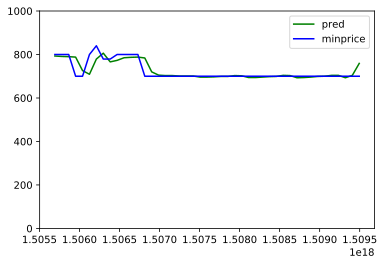

In [80]:
#绘制时间序列图
ts='2017-11-01'
route = '三亚-哈尔滨'
result=valdf_45.loc[(valdf_7.dep_date==ts)&(valdf_7.route == route),['minprice','pred','pre_day','search_date']]
result.info()
result.sort_values(by='pre_day',inplace=True)
plt.plot(result.search_date,result.pred,color='green')
plt.plot(result.search_date,result.minprice,color='blue')
plt.ylim(0,1000)
plt.legend(fontsize=10)
# ax=plt.gca()
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))  #设置时间显示格式
# ax.xaxis.set_major_locator(AutoDateLocator(maxticks=24))       #设置时间间隔  
# result.head()

# 公共函数

In [11]:
def fit_evaluate(train_df,test_df):
    train_X=train_df[train_feature]
    train_y=train_df['minprice']
    test_X=test_df[train_feature]
    test_y=test_df['minprice']
    model_xgb = xgboost_model_train(train_X,train_y,test_X,test_y)   
    #模型保存
    return model_xgb

In [104]:
#days：预测的未来搜索天数
def cross_validation(model_xgb,df,days):
#     按照航线分开处理
    label_list = df.label.unique()[:1]
    res = pd.DataFrame()
    for route_num in label_list:
        valdf = df[df.label==route_num]
        #取验证集最小值为出发日期，历史15天的数据都有
        sday=valdf.dep_date.min() 
        X=valdf.loc[(valdf['search_date']==sday),train_feature]
        val=xgb.DMatrix(X)
        pred=np.round(model_xgb.predict(val,ntree_limit = model_xgb.best_iteration))
        real=valdf.loc[(valdf.dep_date==sday),'minprice'].values
        valdf.loc[valdf.dep_date==sday,'pred']=pred
        a,b = mape_rmse(real,pred)
        loss_mape=[a]
        loss_rmse=[b]
        ts=sday
        p=[pred] # 将每次预测的结果存入列表中
        print(p[0],len(p[0]))
#         for i in range(days):
#             ts=ts+timedelta(1)
#             k = (i)%15
#             for j in range(k+1): # 最多只有15天，只需要历史15天的数据
#                 ps=pd.Series(p[-j-1]) #将上次的预测结果转换为Series类型
#                 valdf.loc[valdf['dep_date']==ts,columns_15d_by_preday[j]]=ps.values
#                 valdf.loc[valdf['dep_date']==ts,columns_15d_by_dep[j]]=ps.shift(-1).values
#             ##增加统计量的信息
#             valdf=stats_feature(valdf)
#             X=valdf.loc[(valdf['dep_date']==ts),train_feature]
#             val=xgb.DMatrix(X)
#             pred=np.round(model_xgb.predict(val,ntree_limit = model_xgb.best_iteration))
#             valdf.loc[valdf.dep_date==ts,'pred']=pred
#             real=valdf.loc[(valdf.dep_date==ts),'minprice'].values
#             a,b = mape_rmse(real,pred)
#             loss_mape.append(a)
#             loss_rmse.append(b)
#             #预测完赋值给第二天
#             p.append(pred)
#         #将预测结果输出到文件中，计算评价损失
# #         print('真实值数量：%s,预测值数量：%s'%(valdf.minprice.shape[0],len(p)))
#         print('\n++++++航线+++++++%s提前%s天预测，交叉验证结果：MAPE:%.3f,RMSE:%.3f'%(route_num,days,np.mean(loss_mape),np.mean(loss_rmse)))
#         res = res.append(valdf)
    return res

In [13]:
# 打印结果
def plotres(resultdf):
    ts='2017-11-03'
    data=valdf.loc[valdf.dep_date==ts,['minprice','pred','search_date']]
    plt.plot(data.minprice,data.search_date)

In [14]:
def mape_rmse(real,pred):
    mape=np.mean(np.abs(pred-real)/real)
    rmse=math.sqrt(mean_squared_error(real, pred))
    print('验证集MAPE%3f,%3f：'%(mape,rmse))    
    return mape,rmse    

#  -------------------特征处理函数-----------------------

In [15]:
def xgboost_model_train(train_X,train_y,test_X,test_y):
    # 模型训练
    xgb_train  = xgb.DMatrix(train_X, train_y)
    xgb_test   = xgb.DMatrix(test_X, test_y)
    params_xgb = {
#         'booster': 'gbtree',                # 取决于使用哪种booster,有两中模型可以选择gbtree和gblinear。gbtree使用基于树的模型进行提升计算，gblinear使用线性模型进行提升计算
        'objective': 'reg:linear',     # 定义学习任务及相应的学习目标，可选的目标函数如下：“reg:linear” —— 线性回归,“reg:logistic”—— 逻辑回归。
        #'multi:softmax'
        'gamma': 0.03,                      # 最小损失减少，模型在默认情况下，对于一个节点的划分只有在其loss function 得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值
        'max_depth': 8,                     # 数的最大深度。缺省值为6，树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合
        'lambda': 4,                        # L2 正则的惩罚系数
        'subsample': 0.8,                   # 用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中随机的抽取出50%的子样本建立树模型，这能够防止过拟合。
        'colsample_bytree': 0.8,            # 在建立树时对特征采样的比例。缺省值为1。
#         'eval_metric':'mape_ln',
        'min_child_weight': 8.5,            # 孩子节点中最小的样本权重和，在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
        'silent': 1,                        # 取0时表示打印出运行时信息，取1时表示以缄默方式运行，不打印运行时信息。缺省值为0。
        'eta': 0.03,                        # 为了防止过拟合，更新过程中用到的收缩步长。通常最后设置eta为0.01~0.2
        'seed': 1000}                       # 随机数的种子。缺省值为0。
    num_boost_round = 2000
    plst  = params_xgb.items()
    model_xgb = xgb.train(plst, xgb_train, num_boost_round,evals=[(xgb_train,'train'),(xgb_test,'test')],early_stopping_rounds=50,verbose_eval=True)
    return model_xgb
# ############################################################################
reg = re.compile('\s+|\t|\n') # 正则匹配空格、Tab键、换行
#列名同一出发日期历史15天每天票价
col_15d_by_dep='''history_1d_by_dep_price,history_2d_by_dep_price,history_3d_by_dep_price,history_4d_by_dep_price
    ,history_5d_by_dep_price,history_6d_by_dep_price,history_7d_by_dep_price,history_8d_by_dep_price
    ,history_9d_by_dep_price,history_10d_by_dep_price,history_11d_by_dep_price,history_12d_by_dep_price
    ,history_13d_by_dep_price,history_14d_by_dep_price,history_15d_by_dep_price'''
columns_15d_by_dep=re.sub(reg,'',col_15d_by_dep).split(',')    
#列名，同一提前天数历史15天每天票价
col_15d_by_preday='''history_1d_by_preday_price,history_2d_by_preday_price,history_3d_by_preday_price,
    history_4d_by_preday_price,history_5d_by_preday_price,history_6d_by_preday_price,
    history_7d_by_preday_price,history_8d_by_preday_price
    ,history_9d_by_preday_price,history_10d_by_preday_price,history_11d_by_preday_price,history_12d_by_preday_price
    ,history_13d_by_preday_price,history_14d_by_preday_price,history_15d_by_preday_price'''
columns_15d_by_preday=re.sub(reg,'',col_15d_by_preday).split(',')    
#列名，同一出发日期历史1周，2周统计量
col_by_dep_stats='''history_1w_by_dep_mean,history_1w_by_dep_var,history_1w_by_dep_min,history_1w_by_dep_max,
    history_1w_by_dep_median,history_1w_by_dep_mode,history_1w_by_dep_decline_count,
    history_1w_by_dep_rise_count,
    history_2w_by_dep_mean,history_2w_by_dep_var,history_2w_by_dep_min,history_2w_by_dep_max,
    history_2w_by_dep_median,history_2w_by_dep_mode,history_2w_by_dep_decline_count,
    history_2w_by_dep_rise_count'''
columns_by_dep_stats=re.sub(reg,'',col_by_dep_stats).split(',')

#列名，同一提前天数历史1周，2周统计量
col_by_preday_stats='''history_1w_by_preday_mean,history_1w_by_preday_var,history_1w_by_preday_min,history_1w_by_preday_max,
    history_1w_by_preday_median,history_1w_by_preday_mode,history_1w_by_preday_decline_count,
    history_1w_by_preday_rise_count,
    history_2w_by_preday_mean,history_2w_by_preday_var,history_2w_by_preday_min,history_2w_by_preday_max,
    history_2w_by_preday_median,history_2w_by_preday_mode,history_2w_by_preday_decline_count,
    history_2w_by_preday_rise_count'''
columns_by_preday_stats=re.sub(reg,'',col_by_preday_stats).split(',')  

#######统计指标总函数
def statistics_feature_engineering(data):
    df=data.copy()
    df=history_15d_by_dep_price_feature(df,columns_15d_by_dep)
    df=history_15d_by_preday_price_feature(df,columns_15d_by_preday)
    df=stats_by_dep_feature(df,columns_by_dep_stats,columns_15d_by_dep)
    df=stats_by_preday_feature(df,columns_by_preday_stats,columns_15d_by_preday)
    return df
# 同一起飞日期，搜索日期的历史15天每天价格
def history_15d_by_dep_price_feature(data,columns):
    start=time.time()
    tmp=data.copy()
    # 同一起飞日期，搜索日期的历史15天每天价格
    # 给新增的列赋值空
    for col in columns:
        tmp[col]=np.nan
    #填充历史价格信息
    dep_dates=pd.to_datetime(tmp.dep_date.unique())    
    null_count=0
    for ts in dep_dates:    
        s_date=tmp.loc[tmp.dep_date==ts,'search_date']
        for ts2 in s_date:        
            for i in range(len(columns)):
                ts_lag=ts2-timedelta(i+1)
                lagging=tmp.loc[(tmp.dep_date==ts) &(tmp.search_date==ts_lag)]['minprice']
                if lagging.empty:
#                     print('do nothing') # 历史价格为空，则不填充
                    null_count+=1 
                else:
                    tmp.loc[(tmp.dep_date==ts)&(tmp.search_date==ts2),columns[i]]=lagging.values
    end=time.time()    
#     print('特征构造-相同起飞日期，历史15天每天搜索价格特征耗时：%d秒,空值数量：%s'%((end-start),null_count))
    return tmp

# 同一提前天数，搜索日期的历史15天每天价格
def history_15d_by_preday_price_feature(data,columns):
    start=time.time()
    tmp=data.copy()    
    # 给新增的列赋值空
    for col in columns:
        tmp[col]=np.nan
    #填充历史价格信息
    dep_dates=pd.to_datetime(tmp.dep_date.unique()) 
    null_count=0
    for ts in dep_dates:    
        preday=tmp.loc[tmp.dep_date==ts,'pre_day']
        for pre in preday:        
            for i in range(len(columns)):
                ts_lag=ts-timedelta(i+1) #从0开始，要+1
                lagging=tmp.loc[(tmp.pre_day==pre) &(tmp.dep_date==ts_lag)]['minprice']
                if lagging.empty:
    #                 print('do nothing') # 历史价格为空，则不填充
                    null_count+=1
                else:
                    tmp.loc[(tmp.dep_date==ts)&(tmp.pre_day==pre),columns[i]]=lagging.values
    end=time.time()    
#     print('特征构造-相同提前天数，历史15天每天搜索价格特征耗时：%d秒,空值数量：%s'%((end-start),null_count))
#     tmp.to_csv('../datasets/tmp_pred_preday_features.csv')
    return tmp

def stats_by_dep_feature(data,columns,names):
    start=time.time()
    df=data.copy() 
    for col in columns:
        df[col]=np.nan
    subset=df[names[0:7]].T
    df['history_1w_by_dep_mean']=subset.mean()
    df['history_1w_by_dep_var']=subset.var()
    df['history_1w_by_dep_min']=subset.min()
    df['history_1w_by_dep_max']=subset.max()
    df['history_1w_by_dep_median']=subset.median()
    mode=subset.mode().iloc[0]    
    df['history_1w_by_dep_mode']=mode
    dr=subset.apply(decline_and_rise_count)#获取上涨和下降次数
    df['history_1w_by_dep_decline_count']=dr.apply(lambda x:x[0])
    df['history_1w_by_dep_rise_count']=dr.apply(lambda x:x[1])    
#     df['history_1w_by_dep_mode_count']=mode.count()  # 暂时不考虑    
#     df['history_1w_by_dep_change_count']=    #暂时不考虑    
###########取15天的统计量
    subset=df[names].T
    df['history_2w_by_dep_mean']=subset.mean()
    df['history_2w_by_dep_var']=subset.var()
    df['history_2w_by_dep_min']=subset.min()
    df['history_2w_by_dep_max']=subset.max()
    df['history_2w_by_dep_median']=subset.median()
    mode=subset.mode().iloc[0]    
    df['history_2w_by_dep_mode']=mode
    dr=subset.apply(decline_and_rise_count)#获取上涨和下降次数
    df['history_2w_by_dep_decline_count']=dr.apply(lambda x:x[0])
    df['history_2w_by_dep_rise_count']=dr.apply(lambda x:x[1])    
    end=time.time()    
    print('特征构造--相同起飞日期价格统计量，耗时：%d秒'%((end-start))) 
    return df

def stats_by_preday_feature(data,columns,names):
    start=time.time()
    df=data.copy() 
    for col in columns:
        df[col]=np.nan
    subset=df[names[0:7]].T
    df['history_1w_by_preday_mean']=subset.mean()
    df['history_1w_by_preday_var']=subset.var()
    df['history_1w_by_preday_min']=subset.min()
    df['history_1w_by_preday_max']=subset.max()
    df['history_1w_by_preday_median']=subset.median()
    mode=subset.mode().iloc[0]    
    df['history_1w_by_preday_mode']=mode
    dr=subset.apply(decline_and_rise_count)#获取上涨和下降次数
    df['history_1w_by_preday_decline_count']=dr.apply(lambda x:x[0])
    df['history_1w_by_preday_rise_count']=dr.apply(lambda x:x[1])    
#     df['history_1w_by_dep_mode_count']=mode.count()  # 暂时不考虑    
#     df['history_1w_by_dep_change_count']=    #暂时不考虑    
###########取15天的统计量
    subset=df[names].T
    df['history_2w_by_preday_mean']=subset.mean()
    df['history_2w_by_preday_var']=subset.var()
    df['history_2w_by_preday_min']=subset.min()
    df['history_2w_by_preday_max']=subset.max()
    df['history_2w_by_preday_median']=subset.median()
    mode=subset.mode().iloc[0]    
    df['history_2w_by_preday_mode']=mode
    dr=subset.apply(decline_and_rise_count)#获取上涨和下降次数
    df['history_2w_by_preday_decline_count']=dr.apply(lambda x:x[0])
    df['history_2w_by_preday_rise_count']=dr.apply(lambda x:x[1])  
    end=time.time()    
    print('特征构造--相同起飞日期价格统计量，耗时：%d秒'%((end-start)))
 
    return df

#计算价格上升和下降次数
def decline_and_rise_count(data): 
    subset = list(data.copy())
    decline = 0
    rise = 0 
    modecount = 0
    for i in range(len(subset)-1):
        if subset[i]>subset[i+1]:
            decline += 1
        if subset[i]<subset[i+1]:
            rise += 1  
#     print(subset.count(mode))
    return decline,rise

#交叉验证添加统计量特征
def stats_feature(data):
    data=stats_by_dep_feature(data,columns_by_dep_stats,columns_15d_by_dep)
    data=stats_by_preday_feature(data,columns_by_preday_stats,columns_15d_by_preday)
    return data
